In [1]:
import pylab as pl

from utils import *
from grm_utils import *

In [2]:
# step 1: read catalogues
xmm12_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_12/XMMLSS_12_1538856059_1539286252_pol_detections.fits'
xmm12 = read_catalogue(xmm12_file)
xmm13_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_13/XMMLSS_13_1538942495_1539372679_pol_detections.fits'
xmm13 = read_catalogue(xmm13_file)
xmm14_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_14/XMMLSS_14_1539028868_1539460932_pol_detections.fits'
xmm14 = read_catalogue(xmm14_file)
cosmos_file = '/Users/ascaife/DATA/MIGHTEE/catalog/COSMOS/COSMOS_1587911796_1524147354_1525613583_pol_detections.fits'
cosmos = read_catalogue(cosmos_file)

In [3]:
# step 2: merge catalogues
mightee = merge_cats([xmm12, xmm13, xmm14, cosmos])
print('# of sources: {}'.format(mightee.shape[0]))

# of sources: 442


# of sources (after z filter): 313


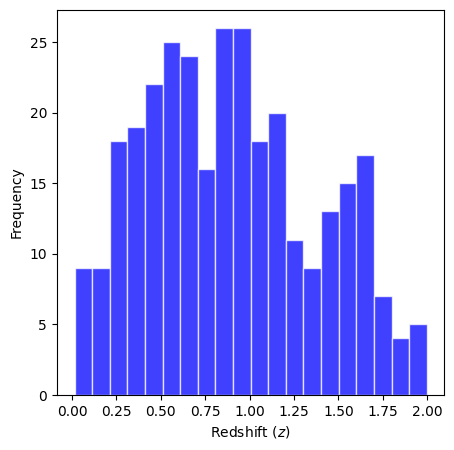

In [4]:
# step 3: redshift and galactic latitude filtering
mightee = filter_z(mightee, has_z=True, spec_z=False)
print('# of sources (after z filter): {}'.format(mightee.shape[0]))

# redshift histogram:
pl.rcParams["figure.figsize"] = (5,5)
pl.subplot(111)
n, bins, patches = pl.hist(mightee['best_z'], density=False, bins=20, edgecolor='w', facecolor='b', alpha=0.75)
pl.xlabel('Redshift ($z$)')
pl.ylabel('Frequency')
pl.show()

In [15]:
# add columns for (l,b)
mightee['l'], mightee['b'] = j2000_to_gal(mightee['ra'].values, mightee['dec'].values)

# filter b<25:
mightee = filter_glat(mightee, bmin=25.)
print('# of sources (after b filter): {}'.format(mightee.shape[0]))
print('lowest gal latitude: {:.2f} deg'.format(np.min(np.abs(mightee['b'].values))))

# of sources (after b filter): 313
lowest gal latitude: 41.67 deg


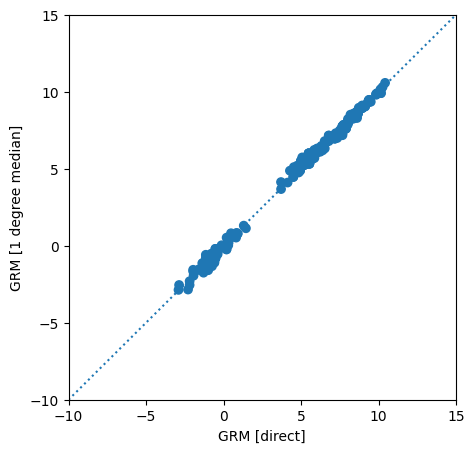

In [6]:
# step 4: get GRMs
ra = np.array(mightee['ra'].values)
dec= np.array(mightee['dec'].values)

fitsfile = './faradaysky/faraday2020v2.fits'
grmdata, grmhp = get_grm_data(fitsfile) # from grm_utils.py

# nearest pixel values:
grm_fs, grm_fs_std = get_grm(ra, dec, grmdata, grmhp) # from grm_utils.py
mightee['GRM_FS'] = grm_fs
mightee['GRM_FSerr'] = grm_fs_std

# 1 degree median values:
grm1_med, grm1_mad, grm1_std = get_grm1(ra, dec, grmdata, grmhp, r=0.5) # 1 degree median values (grm_utils)
mightee['GRM1'] = grm1_med
mightee['GRM1err'] = grm1_mad

pl.rcParams["figure.figsize"] = (5,5)
#pl.errorbar(grm_fs, grm1_med, xerr=grm_fs_std, yerr=grm1_mad, ls='', marker='o')
pl.scatter(grm_fs, grm1_med, ls='', marker='o')
pl.plot([-10,15],[-10,15], ls=':')
pl.xlabel('GRM [direct]')
pl.ylabel('GRM [1 degree median]')
pl.axis([-10,15,-10,15])
pl.show()

In [7]:
# step 5s: subtract off GRMs [direct]
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm     = mightee['GRM_FS'].values      # use 1 deg median
grm_err = mightee['GRM_FSerr'].values   # use 1 deg median
z       = mightee['best_z'].values

# take difference
rrm = rm - grm

# remove data outside 2 sigma:
std = np.std(rrm)
grm_err = grm_err[np.where(np.abs(rrm)<=2*std)]
rrm = rrm[np.where(np.abs(rrm)<=2*std)]
print('# of sources (after 2sig rm subtraction): {}'.format(len(rrm)))

rrm_rms_obs = stats.median_abs_deviation(rrm, scale='normal', nan_policy='omit')
rrm_mad = stats.median_abs_deviation(rrm, nan_policy='omit')

print("---")
print("Using GRM subtraction: ")
print("<RRM^2>^0.5 [direct] : {:.2f} rad/m^2".format(np.std(rrm)))
print("RRM MAD : {:.2f} rad/m^2".format(rrm_mad))
print("<RRM^2>^0.5 [using MAD] : {:.2f} rad/m^2".format(rrm_rms_obs))
print("Average GRM error : {:.2f} rad/m^2".format(np.mean(grm_err)))

# of sources (after 2sig rm subtraction): 310
---
Using GRM subtraction: 
<RRM^2>^0.5 [direct] : 9.22 rad/m^2
RRM MAD : 4.82 rad/m^2
<RRM^2>^0.5 [using MAD] : 7.14 rad/m^2
Average GRM error : 6.00 rad/m^2


---
Using GRM1 subtraction: 
<RRM^2>^0.5 : 6.12 +/- 1.59 rad/m^2


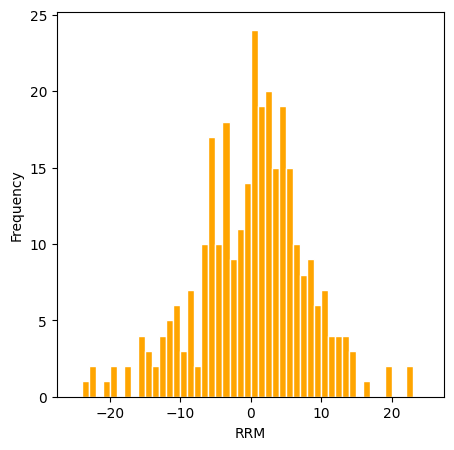

In [8]:
# step 5b: subtract off GRMs [1 deg]
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm     = mightee['GRM1'].values      # use 1 deg median
grm_err = mightee['GRM1err'].values   # use 1 deg median
z       = mightee['best_z'].values

# take difference
rrm = rm - grm

print("---")
print("Using GRM1 subtraction: ")
rrm_rms = np.sqrt(np.std(rrm) - np.std(rm_err) - np.std(grm_err))
se1 = standard_error_on_stdev(np.std(rrm), len(rrm))
se2 = standard_error_on_stdev(np.std(rm_err), len(rm_err))
se3 = standard_error_on_stdev(np.std(grm_err), len(grm_err))
rrm_rms_ste = np.sqrt(se1**2 + se2**2 + se3**2)
print("<RRM^2>^0.5 : {:.2f} +/- {:.2f} rad/m^2".format(rrm_rms, rrm_rms_ste))

pl.rcParams["figure.figsize"] = (5,5)
pl.subplot(111)
n, bins, patches = pl.hist(rrm, density=False, range=(-25,25), bins=50, edgecolor='w', facecolor='orange', alpha=1.0)
pl.xlabel('RRM')
pl.ylabel('Frequency')
pl.show()

---
fexcess: -0.45 +/- 45.34 
fexcess stdev: 67.23


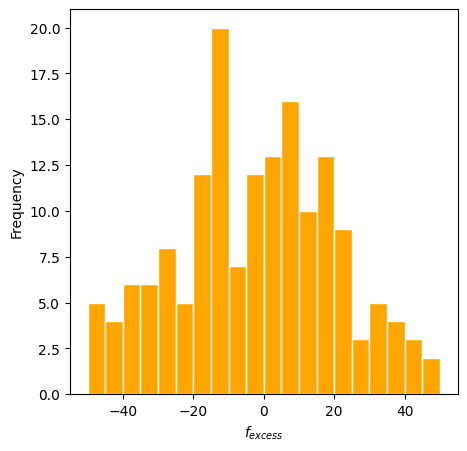

In [9]:
# step 6: calculate f_excess
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm     = mightee['GRM_FS'].values      # use 1 deg median
grm_err = mightee['GRM_FSerr'].values   # use 1 deg median
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values

eps = 1e-7
rm_excess = rm  - grm1
grm_excess= grm - grm1 + eps

f_excess = rm_excess/grm_excess

print("---")
print("fexcess: {:.2f} +/- {:.2f} ".format(np.median(f_excess), stats.median_abs_deviation(f_excess, nan_policy='omit')))
print("fexcess stdev: {:.2f}".format(stats.median_abs_deviation(f_excess, scale='normal', nan_policy='omit')))

pl.rcParams["figure.figsize"] = (5,5)
pl.subplot(111)
n, bins, patches = pl.hist(f_excess, density=False, range=(-50,50), bins=20, edgecolor='w', facecolor='orange', alpha=1.0)
pl.xlabel(r'$f_{excess}$')
pl.ylabel('Frequency')
pl.show()

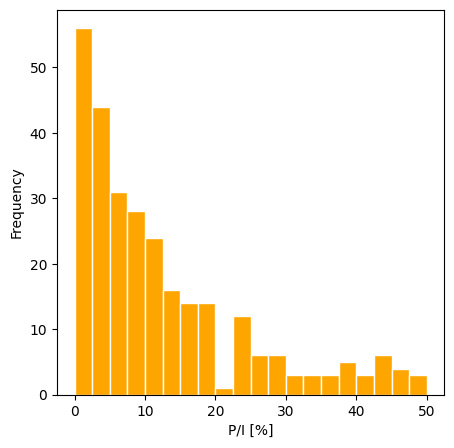

In [12]:
# step 7: pol fraction filtering:
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values
pfrac   = mightee['P/I'].values

pl.rcParams["figure.figsize"] = (5,5)
pl.subplot(111)
n, bins, patches = pl.hist(pfrac, density=False, range=(0,50), bins=20, edgecolor='w', facecolor='orange', alpha=1.0)
pl.xlabel('P/I [%]')
pl.ylabel('Frequency')
pl.show()